In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src.data.preprocessing import get_pre_all_data

data = get_pre_all_data("./data", store_id=1, channel=1, end_date="2023-08-30")
data.head()

,sku_id,store_id,channel,date,original_price,salable_status_0,salable_status_1,stock_status_0,stock_status_1,quantity,...,weather_type_4,weather_type_6,weather_type_7,weather_type_8,weather_type_9,weather_type_10,weather_type_14,weather_type_15,weather_type_18,weather_type_30
0,1,1,1,2022-06-17,0.228152,False,True,False,True,1.0,...,False,False,True,False,False,False,False,False,False,False
1,1,1,1,2022-06-18,0.228152,False,True,False,True,4.0,...,False,False,False,False,False,False,False,False,False,False
2,1,1,1,2022-06-19,0.228152,False,True,False,True,1.0,...,False,False,False,False,False,False,False,False,False,False
3,1,1,1,2022-06-20,0.228152,False,True,True,False,NaN,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,2022-06-21,0.228152,False,True,True,False,NaN,...,False,False,True,False,False,False,False,False,False,False


In [3]:
data.drop(columns=["sku_id", "store_id", "channel"], inplace=True)
data.head()

,date,original_price,salable_status_0,salable_status_1,stock_status_0,stock_status_1,quantity,curr_day,threshold,discount_off,...,weather_type_4,weather_type_6,weather_type_7,weather_type_8,weather_type_9,weather_type_10,weather_type_14,weather_type_15,weather_type_18,weather_type_30
0,2022-06-17,0.228152,False,True,False,True,1.0,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,False
1,2022-06-18,0.228152,False,True,False,True,4.0,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,2022-06-19,0.228152,False,True,False,True,1.0,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,2022-06-20,0.228152,False,True,True,False,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,2022-06-21,0.228152,False,True,True,False,NaN,0.111111,0.662252,0.15,...,False,False,True,False,False,False,False,False,False,False


In [4]:
data = data.set_index("date")

In [5]:
# 划分训练集和测试集
train = data.dropna().iloc[:-30]
test = data.dropna().iloc[-30:]

In [6]:
train_X = train.drop(columns=["quantity"]).values
train_y = train["quantity"].values
test_X = test.drop(columns=["quantity"]).values
test_y = test["quantity"].values
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((71, 27), (71,), (30, 27), (30,))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Attention
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假设您已经有了以下数据集
# train_X, train_y, test_X, test_y

# 创建一个归一化器实例
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# 由于scaler需要2D数据，我们需要在y上增加一个维度进行fit
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 训练并转换数据
train_X_normalized = scaler_X.fit_transform(train_X)
train_y_normalized = scaler_y.fit_transform(train_y)
test_X_normalized = scaler_X.transform(test_X)
test_y_normalized = scaler_y.transform(test_y)

# 将y返回到原来的形状
train_y_normalized = train_y_normalized.ravel()
test_y_normalized = test_y_normalized.ravel()

# LSTM需要三维输入 [样本数, 时间步长, 特征数]
train_X_normalized = train_X_normalized.reshape((train_X_normalized.shape[0], train_X_normalized.shape[1], 1))
test_X_normalized = test_X_normalized.reshape((test_X_normalized.shape[0], test_X_normalized.shape[1], 1))

import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.keras.backend.dot(x, self.W))
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# 创建模型
model = Sequential()
model.add(GRU(128, activation='relu', return_sequences=True, input_shape=(train_X_normalized.shape[1], 1)))
model.add(AttentionLayer())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# 添加早停来防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(train_X_normalized, train_y_normalized, epochs=200, batch_size=8, validation_data=(test_X_normalized, test_y_normalized), verbose=1, callbacks=[early_stopping])

# 进行预测
predictions_normalized = model.predict(test_X_normalized)

# 反归一化预测
predictions = scaler_y.inverse_transform(predictions_normalized.reshape(-1, 1))

# 在这一点上，`predictions`将包含原始比例的预测值，您可以根据需要进行进一步的处理或评估。


Epoch 1/200
9/9 [==============================] - 2s 45ms/step - loss: 0.1081 - val_loss: 0.1363
Epoch 2/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0813 - val_loss: 0.1245
Epoch 3/200
9/9 [==============================] - 0s 14ms/step - loss: 0.0730 - val_loss: 0.1294
Epoch 4/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0679 - val_loss: 0.1284
Epoch 5/200
9/9 [==============================] - 0s 16ms/step - loss: 0.0660 - val_loss: 0.1276
Epoch 6/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0645 - val_loss: 0.1258
Epoch 7/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0675 - val_loss: 0.1256
Epoch 8/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0665 - val_loss: 0.1257
Epoch 9/200
9/9 [==============================] - 0s 16ms/step - loss: 0.0678 - val_loss: 0.1255
Epoch 10/200
9/9 [==============================] - 0s 15ms/step - loss: 0.0670 - val_loss: 0.1259
Epoch 11/200
9/9 [=

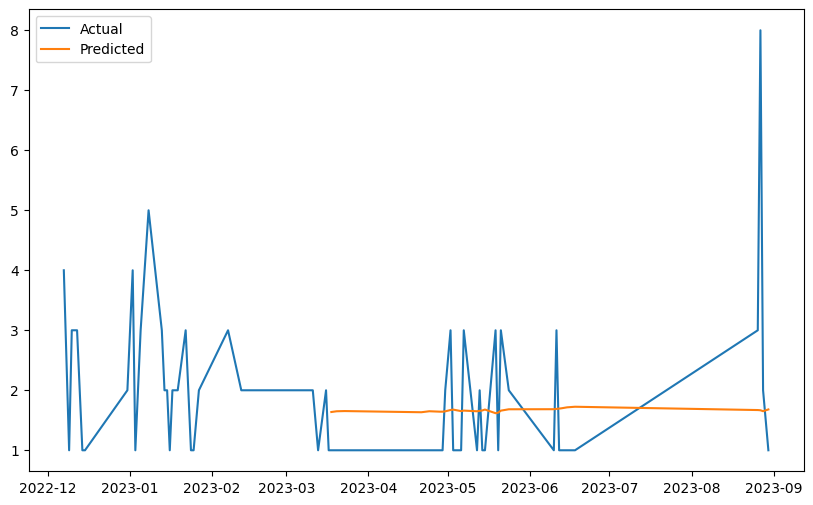

In [11]:
# 将预测结果绘图
plt.figure(figsize=(10, 6))
plt.plot(data.dropna().index[-60:], data.dropna()['quantity'][-60:], label="Actual")
plt.plot(test.index, predictions, label="Predicted")
plt.legend()
plt.show()

In [45]:
# 计算MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y, predictions)
print("RMSE: ", np.sqrt(mse))

RMSE:  2.7381207058874195


In [37]:
train.columns

Index(['original_price', 'salable_status_1', 'stock_status_0',
       'stock_status_1', 'quantity', 'curr_day', 'threshold', 'discount_off',
       'min_temperature', 'max_temperature', 'weather_type_0',
       'weather_type_1', 'weather_type_2', 'weather_type_4', 'weather_type_6',
       'weather_type_7', 'weather_type_8', 'weather_type_9', 'weather_type_10',
       'weather_type_14', 'weather_type_15', 'weather_type_18',
       'weather_type_30'],
      dtype='object')

C:\Users\Yipeng\AppData\Local\Temp\ipykernel_20216\4178386265.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals, bins=50)


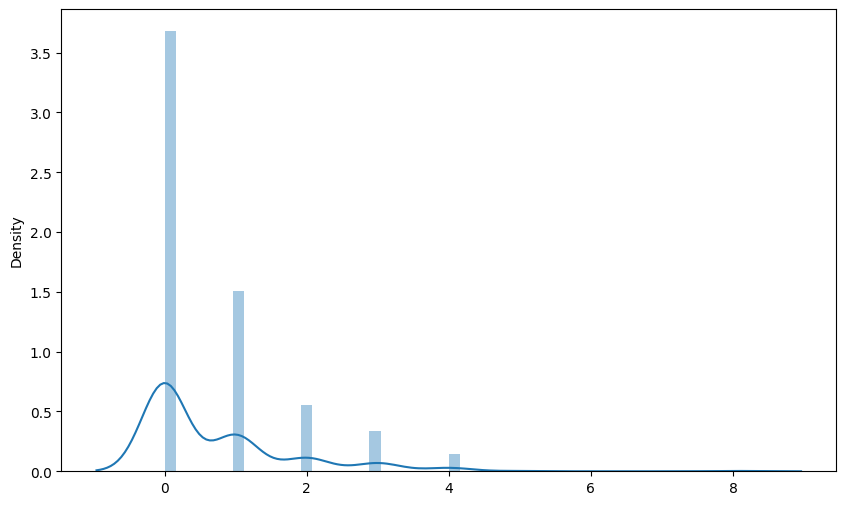

In [43]:
# 统计数量并画图
vals = data['quantity'].fillna(0).values
plt.figure(figsize=(10, 6))
sns.distplot(vals, bins=50)
plt.show()

In [44]:
# 检验是否符合泊松分布
from scipy import stats

# 使用最大似然估计计算λ
lambda_mle = np.mean(vals)

# 使用Kolmogorov-Smirnov检验来测试数据是否符合泊松分布
# 我们使用拟合参数（即lambda_mle）来获取累积分布函数（CDF）
D, p_value = stats.kstest(vals, 'poisson', args=(lambda_mle,))

print(f"K-S statistic: {D}")
print(f"P-value: {p_value}")

# 根据p值判断是否拒绝原假设
if p_value > 0.05:
    print("数据似乎来自泊松分布")
else:
    print("数据似乎不来自泊松分布")

K-S statistic: 0.4954579823605729
P-value: 2.835903922496827e-100
数据似乎不来自泊松分布


In [45]:
from scipy.stats import expon

# 估计λ
lambda_estimated = 1 / np.mean(vals)

# 使用scipy的expon函数来拟合数据
loc, scale = expon.fit(vals, floc=0)

print(f"Estimated lambda: {lambda_estimated}")
print(f"Loc parameter: {loc}")
print(f"Scale parameter (1/λ): {scale}")

Estimated lambda: 1.4239482200647249
Loc parameter: 0.0
Scale parameter (1/λ): 0.7022727272727273


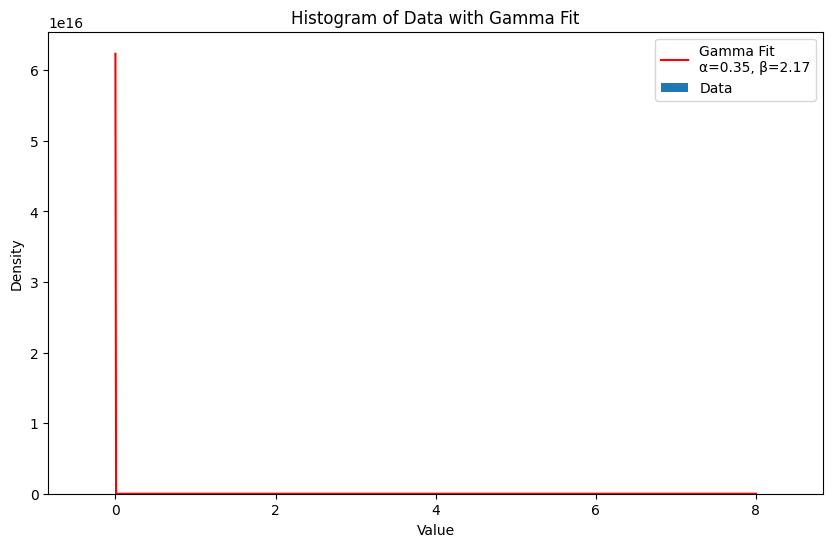

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma


# 将vals转化为(a, p)对，其中a表示值，p表示该值出现的概率
v, p = np.unique(vals, return_counts=True)
p = p / p.sum()

# 使用scipy的gamma函数来拟合数据
a, loc, scale = gamma.fit((v, p))

# 创建一个x轴上的值范围
x = np.linspace(0, max(v), 1000)

# 使用gamma.pdf函数计算伽马分布的概率密度函数值
pdf = gamma.pdf(x, a=a, loc=loc, scale=scale)

# 绘制原始数据的直方图
plt.figure(figsize=(10, 6))

# 绘制直方图
plt.bar(v, p, label='Data')

# 绘制拟合的伽马分布
plt.plot(x, pdf, 'r-', label=f'Gamma Fit\nα={a:.2f}, β={scale:.2f}')

# 显示图例
plt.legend()

# 设置轴标签和标题
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Data with Gamma Fit')

# 显示图形
plt.show()


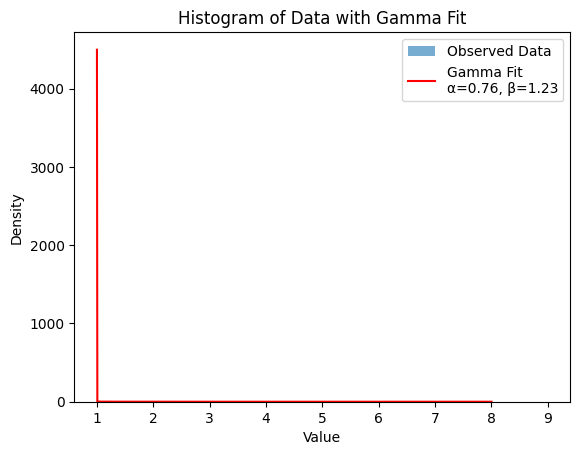

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# 假设我们有以下的vals数据
vals = [1]*100 + [2]*50 + [3]*40 + [4]*25 + [5]*15 + [6]*10 + [7]*5 + [8]*3

# 使用scipy的gamma函数来拟合数据
a, loc, scale = gamma.fit(vals)

# 创建一个x轴上的值范围
x = np.linspace(min(vals), max(vals), 1000)

# 使用gamma.pdf函数计算伽马分布的概率密度函数值
pdf = gamma.pdf(x, a=a, loc=loc, scale=scale)

# 绘制原始数据的直方图
plt.hist(vals, bins=range(1,10), density=True, alpha=0.6, label='Observed Data')

# 绘制拟合的伽马分布
plt.plot(x, pdf, 'r-', label=f'Gamma Fit\nα={a:.2f}, β={scale:.2f}')

# 显示图例
plt.legend()

# 设置轴标签和标题
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Data with Gamma Fit')

# 显示图形
plt.show()
